In [1]:
import sys
sys.path.append('../')
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

In [2]:
from pydens import add_tokens, Solver, NumpySampler, cart_prod
from utils import plot_loss, plot_pair, show_heatmap

## Introductory examples

To begin with, let us go through all of the steps of configuring a `PyDEns`-model using a simple example.

### The easiest example possible: first-order ordinary differential equation in $\mathcal{R}$
$$
\frac{d f}{d t}= 2\pi\cos[2 \pi t]; \quad t \in [0, 1],\ f(0)=1.
$$

The very first thing to do is to add a set of mathematical tokens to the current namespace:

In [3]:
add_tokens()

Configuring `PyDENs`-model comes down to several step:

* setting up dimensionality of the problem:

In [4]:
n_dims = 1

* describing differential form representing the equation

In [5]:
form = lambda u, t: D(u, t) - 2 * np.pi * cos(2 * np.pi * t)

* preparing initial/boundary conditions:

In [6]:
initial_condition = 1 # alternatively, can be callable

* choosing point-sampling scheme

In [7]:
s = NumpySampler('uniform')

in short, each `Sampler` is an entity that samples points: 

In [43]:
s.sample(3)

array([[0.24760844],
       [0.05299496],
       [0.47718886]])

we can now assemble a `configuration-dict` for the pde-problem

In [8]:
pde = {'n_dims': n_dims,
       'form': form,
       'initial_condition': initial_condition}

* **[optional]** set up a neural network architecture using `layout`-string, that specifies the sequence of layers in a network using letters, like `f`(stands for fully connected) or `a` (stands for activation).

In [9]:
body = {'layout': 'fa fa f',
        'units': [10, 25, 1],
        'activation': [tf.nn.tanh, tf.nn.tanh]}

we are all set to assemble the configuration-dict for the whole model

In [10]:
config = {'body': body,
          'pde': pde}

..and initialize the model-instance

In [11]:
model = Solver(config)

it is not ready yet: we still have to train the model

In [12]:
model.fit(batch_size=150, sampler=s, n_iters=2000, bar='notebook')

check out the loss

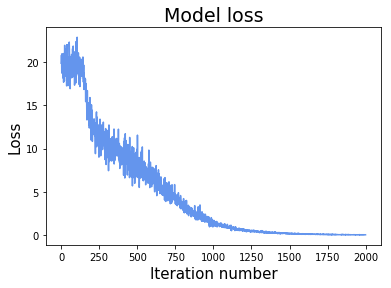

In [13]:
plot_loss(model.loss, color='cornflowerblue')

and the solution along with its network approximation

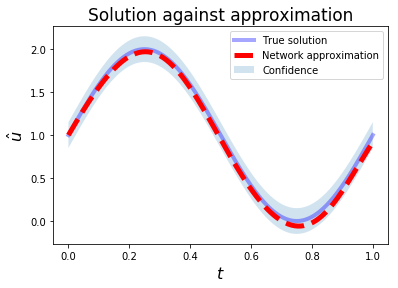

In [14]:
plot_pair(lambda t: np.sin(2*np.pi*t)+1, model, confidence=0.15, alpha=0.2)

### A more interesting one: poisson equation in $\mathcal{R}^2$ with Dirichlet boundary condition

$$\frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} = 5\sin[\pi(x + y)];\quad (x, y) \in [0, 1]^2,\ f(0, y)=f(x, 0)=f(1, y)=f(x, 1)=1.
$$

* setting up dimensionality of the problem:

In [15]:
n_dims = 2

* **Task 1**: implement [laplace operator](https://en.wikipedia.org/wiki/Laplace_operator)

In [17]:
laplace = lambda u, x, y: '...'

* configuring the equation (by setting the differential form)

In [19]:
form = lambda u, x, y: laplace(u,x,y)-5*sin(np.pi*(x+y))

* preparing initial/boundary conditions:

In [20]:
boundary_condition = 1

* **Task 2**: Implement `Sampler` concentrating on the domain-center

In [23]:
s = NumpySampler('uniform', dim=2) | (NumpySampler('normal', dim=2, scale=0.2) + (0.5, 0.5))

assemble `config`-dicts for the model

In [24]:
pde = {'n_dims': n_dims,
       'form': form,
       'boundary_condition': boundary_condition}

config = {'pde': pde}

initialize and train the model-instance

In [27]:
model = Solver(config)
model.fit(batch_size=150, sampler=s, n_iters=700, bar='notebook')

check out the loss

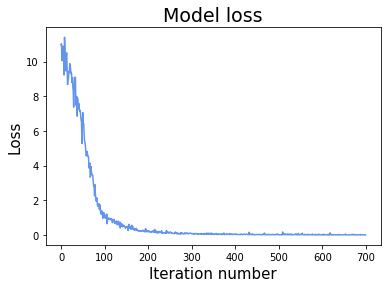

In [28]:
plot_loss(model.loss[:], color='cornflowerblue')

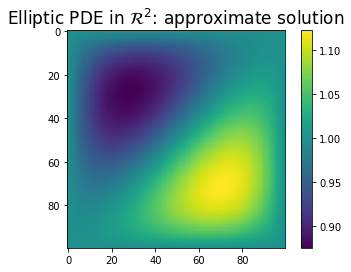

In [29]:
show_heatmap(model)

## Getting closer to the inverse problem

Clearly, `PyDEns` is capable of solving PDEs from a wide family. That being said, the key-novelty (and usefulness for oil&gas) of `PyDEns` lies in its ability to perform well in more complex scenarios: (i) solving *parametric families of PDEs* and (ii) *PDEs with trainable coefficients*. 

### Solving parametric family of PDEs

In the previous examples we've used `PyDEns` to solve **one PDE-problem** in **one training-cycle lasting ~1s**. In the upcoming example we'll be using `PyDEns` to solve **parametric family of PDEs** in **one training-cycle lasting ~3s**.

Again, let us consider simple test example of *a parametric family of equations*:

$$
\frac{d f}{d t}= \epsilon \cos[\epsilon \pi t]; \quad t \in [0, 1],\ f(0)=1.
$$

* **Task 3**: wrap up `e`-var into `P`-token to introduce a parameter into the equation

In [4]:
pde = {'n_dims': 1,
       'form': lambda u, t, e: D(u, t) - P(e) * np.pi * cos(P(e) * np.pi * t),
       'initial_condition': 1}

prepare sampler-instance

In [5]:
s = NumpySampler('uniform')

check out this sampler: it samples points from $\mathcal{R}$:

In [6]:
s.sample(4)

array([[0.39071434],
       [0.32279882],
       [0.25131713],
       [0.51723471]])

yet, we have to learn how to solve equation with different values of parameters. As the result, we have to add *another component* to our sampler:

In [7]:
s = s & NumpySampler('uniform', low=1, high=5)

assemble config-dicts

In [8]:
config = {'pde': pde,
          'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05},
          'track': {'dt': lambda u, t, e: D(u, t)}}

run the training-cycle:

In [9]:
model = Solver(config)
model.fit(batch_size=3000, sampler=s, n_iters=900, bar='notebook')

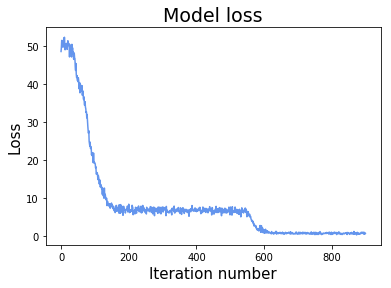

In [10]:
plot_loss(model.loss, color='cornflowerblue')

In [50]:
def plot_pair_custom(e):
    solution = lambda t: np.sin(e * np.pi * t) + 1
    points = np.concatenate([np.linspace(0, 1, 200).reshape(-1, 1),
                             e * np.ones((200, 1))], axis=1)
    plt.scatter([0.5], [1.0], marker='o', alpha=0.4, s=70, label=r'$u(0.5)=1$')
    plot_pair(solution, model, points, n_params=1, confidence=0.15,
              title=r'Solution against approximation: $\epsilon=$' + str(np.round(e, 2)))

In [51]:
_ = interact(plot_pair_custom, e=(1, 5, 0.01))

interactive(children=(FloatSlider(value=3.0, description='e', max=5.0, min=1.0, step=0.01), Output()), _dom_cl…

* **Task 4**: determine value of $\epsilon$ when $u(0.5)=1$

### Solving PDEs with trainable coefficients

## Solving inverse problems